# LSTM part-of-speech tagging for the French Treebank: 

This notebook trains a part-of-speech tagger for the French Treebank using a vanilla bi-direction LSTM network.

Run the following cell to load the Keras packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from keras.models import Model
from keras.layers import Bidirectional, Dense, Input, Dropout, LSTM, Activation, TimeDistributed, BatchNormalization, concatenate, Concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

from grail_data_utils import *

%matplotlib inline

np.random.seed(1)

Using TensorFlow backend.


In [ ]:
# very small initial part of corpus (only file aa1)
# X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('aa1.txt')

In [4]:
# small initial part of corpus (files aa1, aa2, ab2 and ae1)
# number of sentences, train: 1195, test: 398, dev: 399  
# X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('aa1_ae1.txt')

In [63]:
# entire corpus
# number of sentences, train: 9449, test: 3150, dev: 3150
X, Y1, Y2, Z, vocabulary, vnorm, partsofspeech1, partsofspeech2, superset, maxLen = read_maxentdata('m2.txt')

In [61]:
numClasses = len(partsofspeech2)+1
numSuperClasses = len(superset)+1

print()
print("Longest sentence   : ", maxLen)
print("Number of POS tags : ", numClasses)
print("Number of supertags: ", numSuperClasses)



Longest sentence   :  266
Number of POS tags :  32
Number of supertags:  891


## 1. Split the input into train/dev/test

Split the full training set into 60% train, 20% dev and 20% test.

In [62]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_train, Y_testdev = train_test_split(X, Y2, test_size=0.4)
X_test, X_dev, Y_test, Y_dev = train_test_split(X_testdev, Y_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)


Train:  (9449,)
Test:   (3150,)
Dev:    (3150,)


## 2. Create auxiliary mappings

Create mappings from supertags and the two sets of part-of-speech tags to integers and back.

In [64]:
# create mapping for the two POS tagset and for the supertags

super_to_index, index_to_super = indexify(superset)
pos1_to_index, index_to_pos1 = indexify(partsofspeech1)
pos2_to_index, index_to_pos2 = indexify(partsofspeech2)
print(pos2_to_index)

{'PRO:REL': 1, 'VER:simp': 2, 'NAM': 3, 'VER:ppre': 4, 'DET:ART': 5, 'SYM': 6, 'ABR': 7, 'ADJ': 8, 'KON': 9, 'VER:cond': 10, 'VER:pres': 11, 'NOM': 12, 'VER:futu': 13, 'INT': 14, 'VER:impf': 15, 'NUM': 16, 'PRO:IND': 17, 'PUN': 18, 'PRO:PER': 19, 'PRO': 20, 'ADV': 21, 'VER:subp': 22, 'PRP:det': 23, 'VER:pper': 24, 'VER:impe': 25, 'PUN:cit': 26, 'DET:POS': 27, 'PRO:DEM': 28, 'PRO:POS': 29, 'VER:infi': 30, 'PRP': 31}


## 3. Obtain the word vector information

We are using a shell call to the compiled fastText code to produce a file _vectors.txt_ with the relevant vectors. 

### 3.1. Special treatment for numbers

fastText does not include native numbers; internally, these are translated into sequences of the words "zéro", "un", etc. 

We add new entries averaging over the number symbols for numbers appearing in the French Treebank.

In [9]:
with open("num_vec.txt", 'r') as f:
    number = {}
    for line in f:
        line = line.strip().split()
        numc = line[0]
        emb = np.array(line[1:], dtype=np.float64)
        number[numc] = emb

In [10]:
for i in number.keys():
    print(i)

0
1
2
3
4
5
6
7
8
9
,
.
-
/


### 3.2. Feature vectors

#### Suffixes

In [ ]:
french_suffixes = read_suffixes('suffixes.txt')
print(len(french_suffixes))

In [18]:
suffix_vector("seraient", french_suffixes)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

#### Manually designed features

In [99]:
print(word_features("ABCD"))
print(word_features("Abcd"))
print(word_features("1234"))
print(word_features("*%"))
print(word_features("Ab-cd"))
print(word_features("-t-il"))
print(word_features("Contre"))
print(word_features("dans"))
print(word_features("anti-"))
print(word_features("et"))
print(word_features("ou"))
print(word_features("-t-il"))
print(word_features("-il"))
print(word_features("-tu"))
print(word_features("eussent"))

[ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 

### 3.3. Sending the vocabulary through the fasttext executable

Write the vocabulary to an output file, then pass it to the fastText executable to produce the relevant word embeddings for our text. Since the fastText model is over 5 Gb, the shell call can take some time.

In [94]:
with open("vocab.txt", 'w') as vocab_file:
    for w in vnorm:
        print(w, file=vocab_file)

Shell call to `fasttext` for my Macbook Air

In [ ]:
!/Users/moot/Software/fastText-master/fasttext print-word-vectors /Users/moot/Corpus/wiki.fr/wiki.fr.bin < vocab.txt > vectors.txt

Shell call to `fasttest` for my Macbook Pro, with `wiki.fr.bin` on external drive

In [100]:
!/Users/moot/Software/fastText-master/fasttext print-word-vectors /Volumes/LaCie/Corpus/fastText/wiki/wiki.fr.bin < vocab.txt > vectors.txt

#### Combine all vector information

Combined all information from fasttext, suffixes, manually selected features and the features for digits (which are not in fasttext) to produce combined feature vectors for all words 

In [102]:
word_to_index, index_to_word, word_to_vec_map = read_vecs('vectors.txt')

### 3.4 - The Embedding layer

In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding. In this part, we create an [Embedding()](https://keras.io/layers/embeddings/) layer in Keras, and initialize it with the fastTeX vectors loaded earlier in the notebook. 

The `Embedding()` layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.

The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

We first convert all our training sentences into lists of indices, and then zero-pad all these lists so that their length is the length of the longest sentence. 

**TODO**: I'd like try if it makes any difference to add the </s> end tag to the end of each sentence. 

Run the following cell to check what `sentences_to_indices()` does, and check your results.

In [105]:
sentences_to_indices(X_train, word_to_index, maxLen)

array([[ 25333.,  18015.,  15541., ...,      0.,      0.,      0.],
       [ 22968.,    342.,  24828., ...,      0.,      0.,      0.],
       [ 17688.,  10362.,  22915., ...,      0.,      0.,      0.],
       ..., 
       [ 34528.,  15584.,  25319., ...,      0.,      0.,      0.],
       [ 22139.,  18264.,  15531., ...,      0.,      0.,      0.],
       [ 21058.,  20941.,  22717., ...,      0.,      0.,      0.]])

We now build the `Embedding()` layer for use with Keras, using pre-trained word vectors. After this layer is built, we can pass the output of `sentences_to_indices()` to it as an input, and the `Embedding()` layer will return the word embeddings for a sentence. 

We use the following steps:
1. Initialize the embedding matrix as a numpy array of zeroes with the correct shape.
2. Fill in the embedding matrix with all the word embeddings extracted from `word_to_vec_map`.
3. Define Keras embedding layer. Use [Embedding()](https://keras.io/layers/embeddings/). Be sure to make this layer non-trainable, by setting `trainable = False` when calling `Embedding()`. If you were to set `trainable = True`, then it will allow the optimization algorithm to modify the values of the word embeddings. 
4. Set the embedding weights to be equal to the embedding matrix 

In [106]:

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 2                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["est"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len,emb_dim,trainable=False,mask_zero=True)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [107]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][2][1] =", embedding_layer.get_weights()[0][2][1])

weights[0][2][1] = 0.19175


**Expected Output**:

<table>
    <tr>
        <td>
            **weights[0][2][1] =**
        </td>
        <td>
           0.19175
        </td>
    </tr>
</table>

## 4. Building the Part-of-Speech tagger

We now build the POS-tagger model using the previously built enbedding layer and feed its output to a bidirectional LSTM network with 128 states in each direction. 



In [108]:
# POS_model

def POS_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    X = BatchNormalization()(X)
    Y = Dropout(0.5)(X)
    # Add a (time distributed) Dense layer followed by a softmax activation
    Y = TimeDistributed(Dense(numClasses, activation='softmax'))(Y)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=Y)
        
    return model

Run the following cell to create your model and check its summary. Because all sentences in the dataset are less than 10 words, we chose `max_len = 10`.  You should see your architecture, it uses "20,223,927" parameters, of which 20,000,050 (the word embeddings) are non-trainable, and the remaining 223,877 are. Because our vocabulary size has 400,001 words (with valid indices from 0 to 400,000) there are 400,001\*50 = 20,000,050 non-trainable parameters. 

In [109]:
model = POS_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 266)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 266, 530)          18862700  
_________________________________________________________________
lstm_4 (LSTM)                (None, 266, 128)          337408    
_________________________________________________________________
batch_normalization_4 (Batch (None, 266, 128)          512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 266, 128)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 266, 32)           4128      
Total params: 19,204,748
Trainable params: 341,792
Non-trainable params: 18,862,956
__________________________________________________________

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use. Compile your model using `categorical_crossentropy` loss, `adam` optimizer and `['accuracy']` metrics:

In [110]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

It's time to train your model. Your Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). We thus have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [111]:
X_train_indices = lists_to_indices(X_train, word_to_index, maxLen)
Y_train_indices = lists_to_indices(Y_train, pos2_to_index, maxLen)
Y_train_oh = to_categorical(Y_train_indices, num_classes=numClasses)

In [112]:
print(Y_train_indices[1])
print(Y_train_oh[1])

[  5.  16.  12.   8.  23.  12.   3.  11.  24.  24.  31.  16.  12.  31.  12.
   8.  18.  12.  18.   1.  11.  31.   8.  12.   9.  26.  21.   8.  23.  12.
   3.  26.  18.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.  

In [113]:
X_dev_indices = lists_to_indices(X_dev, word_to_index, max_len = maxLen)
Y_dev_indices = lists_to_indices(Y_dev, pos2_to_index, max_len = maxLen)
Y_dev_oh = to_categorical(Y_dev_indices, num_classes = numClasses)

Fit the Keras model on `X_train_indices` and `Y_train_oh`. We will use `epochs = 50` and `batch_size = 32`.

In [ ]:
history = model.fit(X_train_indices, Y_train_oh, epochs = 30, batch_size = 32, shuffle=True, validation_data=(X_dev_indices,Y_dev_oh))

Train on 9449 samples, validate on 3150 samples
Epoch 1/30
9449/9449 [==============================] - 192s 20ms/step - loss: 0.5163 - acc: 0.8716 - val_loss: 0.0948 - val_acc: 0.9740
Epoch 2/30
9449/9449 [==============================] - 191s 20ms/step - loss: 0.1100 - acc: 0.9701 - val_loss: 0.0721 - val_acc: 0.9793
Epoch 3/30
9449/9449 [==============================] - 185s 20ms/step - loss: 0.0851 - acc: 0.9757 - val_loss: 0.0660 - val_acc: 0.9802
Epoch 4/30
9449/9449 [==============================] - 194s 20ms/step - loss: 0.0748 - acc: 0.9783 - val_loss: 0.0614 - val_acc: 0.9822
Epoch 5/30
9449/9449 [==============================] - 191s 20ms/step - loss: 0.0681 - acc: 0.9801 - val_loss: 0.0604 - val_acc: 0.9827
Epoch 6/30
9449/9449 [==============================] - 191s 20ms/step - loss: 0.0632 - acc: 0.9811 - val_loss: 0.0547 - val_acc: 0.9836
Epoch 7/30
9449/9449 [==============================] - 193s 20ms/step - loss: 0.0585 - acc: 0.9824 - val_loss: 0.0531 - val_acc: 

Your model should perform close to **100% accuracy** on the training set. The exact accuracy you get may be a little different. Run the following cell to evaluate your model on the test set. 

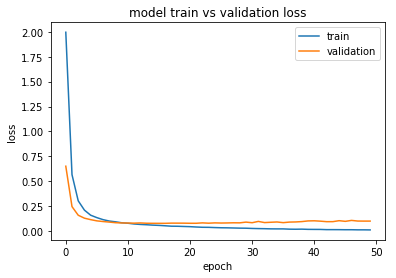

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

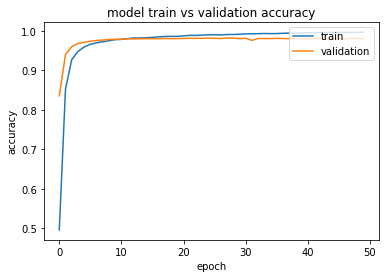

In [39]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [40]:
loss, acc = model.evaluate(X_dev_indices, Y_dev_oh)
print()
print("Test accuracy = ", acc)

399/399 [==============================] - 1s 4ms/step

Test accuracy =  0.98049475092


You should get a test accuracy of about 94.8% for a vanilla model using only aa1.txt.
A vanilla POS model on the full training set gets a dev accuracy of 98.50%!

In [ ]:
X_dev_indices = lists_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_dev_indices)

# print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
# print(pd.crosstab(Y_dev, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_dev, pred)

In [41]:
# This code allows you to see the mislabelled examples

y_dev_oh = to_categorical(Y_dev_indices, num_classes = numClasses)
X_dev_indices = lists_to_indices(X_dev, word_to_index, maxLen)
pred = model.predict(X_dev_indices)

correct = 0
wrong = 0


for i in range(len(X_dev)-1):
    for j in range(len(X_dev[i])):
        num = np.argmax(pred[i][j])
        if(num != Y_dev_indices[i][j]):
            wrong = wrong + 1
            print('Expected POS tag: '+ X_dev[i][j] + '|' + Y_dev[i][j] + ' prediction: '+ X_dev[i][j] + '|' + index_to_pos2[num])
        else:
            correct = correct + 1
total = wrong + correct
print("Total  : ", total)
print("Correct: ", correct)
print("Wrong  : ", wrong)

cpct = (100*correct)/total
wpct = (100*wrong)/total
print("Correct %: ", cpct)
print("Wrong   %: ", wpct)

Expected POS tag: le|PRO:PER prediction: le|DET:ART
Expected POS tag: qu'|PRO:REL prediction: qu'|KON
Expected POS tag: connus|VER:pper prediction: connus|ADJ
Expected POS tag: alourdis|VER:pper prediction: alourdis|ADJ
Expected POS tag: croisés|VER:pper prediction: croisés|ADJ
Expected POS tag: horaire|ADJ prediction: horaire|NOM
Expected POS tag: qu'|KON prediction: qu'|PRO:REL
Expected POS tag: depuis|ADV prediction: depuis|PRP
Expected POS tag: Lever|NAM prediction: Lever|VER:infi
Expected POS tag: anglo-néerlandaise|ADJ prediction: anglo-néerlandaise|NOM
Expected POS tag: hertziennes|ADJ prediction: hertziennes|VER:pper
Expected POS tag: nette|ADJ prediction: nette|NOM
Expected POS tag: suspectés|VER:pper prediction: suspectés|ADJ
Expected POS tag: automobiles|NOM prediction: automobiles|ADJ
Expected POS tag: irrités|VER:pper prediction: irrités|ADJ
Expected POS tag: vite|ADJ prediction: vite|ADV
Expected POS tag: logique|NOM prediction: logique|ADJ
Expected POS tag: poussée|NOM p

### POStagger results on development set

| tagset | LTSM units | batchnorm | dropout | epochs | results |
|:-----|---------:|:----------:|-------:|-----:|----------:|
| tt | 128 | no | 0 |  50 | 98.50 |


In [ ]:
model.save('tt_pos.h5')

## 5. Training the Supertagger

We split the data as before, only using Z (supertags) instead of Y2 (treetagger POStag set) as the goal

In [42]:
# split the training data into the standard 60% train, 20% dev, 20% test 
X_train, X_testdev, Y_super_train, Y_super_testdev = train_test_split(X, Z, test_size=0.4)
X_test, X_dev, Y_super_test, Y_super_dev = train_test_split(X_testdev, Y_super_testdev, test_size=0.5)
print("Train: ", X_train.shape)
print("Test:  ", X_test.shape)
print("Dev:   ", X_dev.shape)

Train:  (1195,)
Test:   (398,)
Dev:    (399,)


In [ ]:
# Super_model
# this is a direct supertag model not using the part-of-speech tags

def Super_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings) 
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    
    # Add a (time distributed) Dense layer followed by a softmax activation
    X = TimeDistributed(Dense(numSuperClasses, activation='softmax'))(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
        
    return model

In [ ]:
supermodel = Super_model((maxLen,), word_to_vec_map, word_to_index)
supermodel.summary()

In [ ]:
supermodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
X_train_indices = lists_to_indices(X_train, word_to_index, maxLen)
Y_super_train_indices = lists_to_indices(Y_super_train, super_to_index, maxLen)
Y_super_train_oh = to_categorical(Y_super_train_indices, num_classes=numSuperClasses)

In [48]:
print(Y_super_train_indices[2][1])
print(Y_super_train_oh[2][1])

430.0
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [49]:
X_dev_indices = lists_to_indices(X_dev, word_to_index, max_len = maxLen)
Y_super_dev_indices = lists_to_indices(Y_super_dev, super_to_index, max_len = maxLen)
Y_super_dev_oh = to_categorical(Y_super_dev_indices, num_classes = numSuperClasses)

In [ ]:
history = supermodel.fit(X_train_indices, Y_super_train_oh, epochs = 10, batch_size = 32, shuffle=True, validation_data=(X_dev_indices,Y_super_dev_oh))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
loss, acc = supermodel.evaluate(X_dev_indices, Y_super_dev_oh)
print()
print("Test accuracy = ", acc)

In [ ]:
supermodel.save('supertagger.h5')

### Supertagger results on development set

| LTSM units | batchnorm | dropout | epochs | results |
|---------:|:----------:|-------:|----:|----------:|
| 128 | yes | .2 |  50 | 80.21 |
| 256 | yes | .2 |  50 | |

In [54]:
tag_sequence("yves acceptera le lait", model, word_to_index, index_to_pos2)

yves|PRO:PER acceptera|VER:futu le|DET:ART lait|NOM 

In [56]:
tag_sequence("yves acceptera le lait", superposmodel, word_to_index, index_to_super)

yves|np acceptera|dr(0,dl(0,np,s),dl(0,np,s_inf)) le|dr(0,np,n) lait|n 

In [58]:
print_tagged(X_dev, model, word_to_index, index_to_pos2, maxLen)

Par|PRP petits|ADJ groupes|NOM ,|PUN chacun|PRO:IND va|VER:pres commentant|VER:ppre le|DET:ART futur|NOM ou|KON ,|PUN comme|ADV dans|PRP les|DET:ART vieux|ADJ couples|NOM qui|PRO:REL n'|ADV arrivent|VER:pres pas|ADV à|PRP se|PRO:PER faire|VER:infi à|PRP l'|DET:ART idée|NOM du|PRP:det veuvage|NOM ,|PUN ressassant|VER:ppre le|DET:ART passé|NOM .|PUN 
En|PRP un|DET:ART an|NOM (|PUN décembre|NOM 1991|ADJ comparé|VER:pper à|PRP décembre|NOM 1990|ADJ )|PUN ,|PUN la|DET:ART hausse|NOM des|PRP:det prix|NOM de|PRP détail|NOM est|VER:pres de|PRP 3,1|DET:ART %|SYM .|PUN 
Le|DET:ART repli|NOM du|PRP:det mark|NOM a|VER:pres ,|PUN très|ADV logiquement|ADV ,|PUN été|VER:pper profitable|ADJ pour|PRP les|DET:ART autres|ADJ monnaies|NOM du|PRP:det système|NOM monétaire|ADJ européen|ADJ ,|PUN surtout|ADV le|DET:ART franc|NOM français|ADJ ,|PUN le|DET:ART cours|NOM de|PRP la|DET:ART devise|NOM allemande|ADJ revenant|VER:ppre ,|PUN à|PRP Paris|NAM ,|PUN à|PRP son|DET:POS cours|NOM d'|PRP il|PRO:PER y|PRO:P

Cette|PRO:DEM dix-septième|NUM édition|NOM ,|PUN réalisée|VER:pper sous|PRP la|DET:ART direction|NOM de|PRP Michel|NAM Boyer|NAM ,|PUN comprend|VER:pres 192|DET:ART pages|NOM et|KON de|PRP nombreuses|ADJ illustrations|NOM .|PUN 
"|PUN:cit C'|PRO:DEM est|VER:pres tout|ADV le|DET:ART contraire|NOM !|PUN ,|PUN affirme|VER:pres même|ADV Anne-Marie|NAM Meissonnier|NAM .|PUN 
À|PRP ces|PRO:DEM cinq|DET:ART départs|NOM du|PRP:det bureau|NOM confédéral|ADJ ,|PUN trois|DET:ART autres|ADJ sont|VER:pres susceptibles|ADJ de|PRP s'|PRO:PER ajouter|VER:infi :|PUN ceux|PRO:DEM de|PRP Mme|ABR Jacqueline|ADJ Léonard|NAM et|KON de|PRP MM.|ABR Johannès|NAM Galland|NAM et|KON Jean-Claude|NAM Laroze|NAM .|PUN 
Il|PRO:PER devra|VER:futu toutefois|ADV se|PRO:PER plier|VER:infi aux|PRP:det règles|NOM en|PRP vigueur|NOM -|PUN n'|ADV avait|VER:impf -il|ADV pas|ADV souscrit|VER:pper aux|PRP:det promesses|NOM faites|VER:pper par|PRP Hachette|NAM en|PRP octobre|NOM 1990|ADJ ,|PUN aux|PRP:det côtés|NOM duquel|PRO:R

Il|PRO:PER est|VER:pres ainsi|ADV possible|ADJ ,|PUN avec|PRP un|DET:ART petit|ADJ laser|NOM ,|PUN de|PRP projeter|VER:infi des|DET:ART images|NOM directement|ADV sur|PRP la|DET:ART rétine|NOM humaine|ADJ .|PUN 
L'|DET:ART affaire|NOM Avia|ADJ connaîtra|VER:futu -t-elle|DET:ART le|DET:ART même|ADJ sort|NOM que|KON Skoda|NAM ?|PUN 
Pour|PRP une|DET:ART simplification|NOM ,|PUN c'|PRO:DEM était|VER:impf une|DET:ART simplification|NOM !|PUN 
D'|PRP autant|ADV que|KON ces|DET:ART programmes|NOM servent|VER:pres aussi|ADV d'|PRP appâts|NOM pour|PRP attirer|VER:infi ,|PUN grâce|VER:pres aux|PRP:det enfants|NOM ,|PUN le|DET:ART public|NOM des|PRP:det parents|NOM .|PUN 
La|DET:ART compagnie|NOM d'|PRP assurances|NOM néerlandaise|ADJ Aegon|NAM NV|ABR a|VER:pres récemment|ADV procédé|VER:pper à|PRP un|DET:ART tirage|NOM de|PRP ce|PRO:DEM genre|NOM .|PUN 
Ceux-ci|PRO:DEM prévoient|VER:pres en|PRP effet|NOM que|KON l'|DET:ART exonération|NOM peut|VER:pres aussi|ADV être|VER:infi acquise|VER:pper p

Pour|PRP qu'|KON une|DET:ART telle|ADJ comparaison|NOM soit|VER:subp valable|ADJ ,|PUN il|PRO:PER faudrait|VER:pres que|KON les|DET:ART actions|NOM sur|PRP les|DET:ART prix|NOM soient|VER:subp accompagnées|VER:pper de|PRP nombreuses|ADJ autres|ADJ mesures|NOM :|PUN autorisation|PRP de|PRP la|DET:ART propriété|NOM privée|ADJ (|PUN des|DET:ART terres|NOM et|KON des|PRP:det entreprises|NOM )|PUN ,|PUN libéralisation|NOM des|PRP:det échanges|NOM internationaux|ADJ ,|PUN création|NOM d'|PRP un|DET:ART droit|NOM des|PRP:det entreprises|NOM (|PUN notamment|ADV sur|PRP les|DET:ART faillites|NOM )|PUN ,|PUN etc|ABR .|PUN 
Le|DET:ART président|NOM en|PRP a|VER:pres profité|VER:pper pour|PRP révéler|VER:infi une|DET:ART partie|NOM des|PRP:det mesures|NOM qu'|PRO:REL il|PRO:PER annoncerait|VER:cond à|PRP la|DET:ART fin|NOM du|PRP:det mois|NOM :|PUN diminution|VER:pres de|PRP la|DET:ART taxation|NOM sur|PRP les|DET:ART plus-values|NOM mobilières|ADJ ,|PUN extension|NOM des|PRP:det crédits|NOM d'|PR

Le|DET:ART juge|NOM des|PRP:det référés|NOM du|PRP:det tribunal|NOM de|PRP grande|ADJ instance|NOM de|PRP Paris|NAM a|VER:pres d'|PRP autre|ADJ part|NOM rejeté|VER:pper la|DET:ART demande|NOM de|PRP la|DET:ART CFDT|ABR visant|VER:ppre à|PRP faire|VER:infi fixer|VER:infi à|PRP 200.000|DET:POS francs|NOM l'|DET:ART astreinte|NOM de|PRP 50.000|DET:POS francs|NOM par|PRP heure|NOM d'|PRP ouverture|NOM ,|PUN définie|VER:pper le|DET:ART 27|ADJ décembre|NOM .|PUN 
D'|PRP ores|NOM et|KON déjà|ADV ,|PUN les|DET:ART entreprises|NOM dont|PRO:REL l'|DET:ART effectif|NOM se|PRO:PER situe|VER:pres entre|PRP 50|DET:POS et|KON 400|NUM salariés|NOM acquittent|VER:pres leurs|DET:POS cotisations|NOM le|PRO:PER 5|ADJ du|PRP:det mois|NOM au|PRP:det lieu|NOM du|PRP:det 15|ADJ et|KON le|DET:ART versement|NOM des|PRP:det dotations|NOM aux|PRP:det hôpitaux|NOM a|VER:pres été|VER:pper modifié|VER:pper .|PUN 
La|DET:ART BCCI|ABR SA|ABR et|KON la|DET:ART BCCI|ABR Holding|NOM ont|VER:pres toutes|ADV deux|DET:ART l

Ceux-ci|PRO:DEM feront|VER:futu partie|VER:pres d'|PRP un|DET:ART ensemble|NOM de|PRP mesures|NOM "|PUN:cit destinées|VER:pper à|PRP favoriser|VER:infi la|DET:ART croissance|NOM "|PUN:cit ,|PUN dont|PRO:REL le|DET:ART contenu|NOM exact|ADJ sera|VER:futu révélé|VER:pper le|DET:ART 28|ADJ janvier|NOM à|PRP l'|DET:ART occasion|NOM du|PRP:det traditionnel|ADJ message|NOM du|PRP:det président|NOM sur|PRP l'|DET:ART état|NOM de|PRP l'|DET:ART union|NOM .|PUN 
La|DET:ART deuxième|NUM solution|NOM est|VER:pres souvent|ADV plus|ADV coûteuse|ADJ que|KON la|DET:ART première|NUM .|PUN 
En|PRP fonction|NOM de|PRP cet|PRO:DEM "|PUN:cit objectif|NOM annuel|ADJ "|PUN:cit ,|PUN les|DET:ART tarifs|NOM seront|VER:futu ajustés|VER:pper à|PRP la|DET:ART baisse|NOM ou|KON à|PRP la|DET:ART hausse|NOM .|PUN 
ce|PRO:DEM sera|VER:futu probablement|ADV un|DET:ART de|PRP ses|DET:POS principaux|ADJ clients|NOM dont|PRO:REL elle|PRO:DEM connaît|VER:pres les|DET:ART besoins|NOM financiers|ADJ .|PUN 
"|PUN:cit Nous|P

L'|DET:ART administrateur|NOM judiciaire|ADJ nommé|VER:pper la|DET:ART semaine|NOM dernière|ADJ (|PUN le|DET:ART Monde|NOM daté|VER:pper 5|PRO:IND -|PUN 6|DET:ART janvier|NOM )|PUN ,|PUN Me|ABR Hubert|VER:pres Lafont|NAM ,|PUN a|VER:pres souligné|VER:pper aussitôt|KON que|KON le|DET:ART délai|NOM de|PRP trois|DET:ART mois|NOM qui|PRO:REL lui|PRO:PER avait|VER:impf été|VER:pper accordé|VER:pper pour|PRP élaborer|VER:infi des|DET:ART solutions|NOM de|PRP survie|NOM pour|PRP la|DET:ART chaîne|NOM "|PUN:cit ne|ADV signifiait|VER:impf rien|PRO:IND :|PUN si|KON aucune|DET:ART solution|NOM n'|ADV est|VER:pres possible|ADJ ,|PUN ma|DET:POS mission|NOM durera|VER:futu trois|DET:ART semaines|NOM .|PUN 
Comment|ADV concilier|VER:infi la|DET:ART protection|NOM des|PRP:det investissements|NOM des|PRP:det constructeurs|NOM automobiles|ADJ dans|PRP des|DET:ART réseaux|NOM de|PRP distributeurs|NOM spécialisés|ADJ avec|PRP le|DET:ART droit|NOM du|PRP:det consommateur|NOM d'|PRP acheter|VER:infi des|DET

En|PRP Allemagne|NOM même|ADJ ,|PUN le|DET:ART rendement|NOM des|PRP:det emprunts|NOM d'|PRP Etat|NOM est|VER:pres revenu|VER:pper des|PRP:det 8,20|NUM %|SYM -|PUN 8,35|DET:ART %|SYM de|PRP ce|PRO:DEM dernier|ADJ mois|NOM à|PRP 8|DET:ART %|SYM et|KON moins|ADV :|PUN c'|PRO:DEM est|VER:pres à|PRP 8|DET:ART %|SYM qu'|PRO:REL ont|VER:pres été|VER:pper adjugés|VER:pper les|DET:ART 4,55|ADJ milliards|NOM de|PRP marks|NOM d'|PRP obligations|NOM du|PRP:det Fonds|NOM de|PRP l'|DET:ART unité|NOM ,|PUN s'|PRO:PER ajoutant|VER:ppre aux|PRP:det 3|ADJ milliards|NOM de|PRP marks|NOM du|PRP:det début|NOM de|PRP la|DET:ART semaine|NOM ,|PUN soit|KON ,|PUN au|PRP:det total|NOM ,|PUN l'|DET:ART équivalent|NOM de|PRP 28|DET:ART milliards|NOM de|PRP francs|NOM .|PUN 
Mais|KON ce|PRO:DEM géant|NOM social|ADJ est|VER:pres demeuré|VER:pper un|DET:ART "|PUN:cit nain|NOM financier|ADJ "|PUN:cit (|PUN 2|DET:ART )|PUN :|PUN le|DET:ART chiffre|NOM d'|PRP affaires|NOM cumulé|VER:pper de|PRP toutes|ADV les|DET:ART 

Dans|PRP le|DET:ART cadre|NOM de|PRP son|DET:POS programme|NOM de|PRP soutien|NOM à|PRP l'|DET:ART automobile|NOM américaine|ADJ ,|PUN Toyota|NAM entend|VER:pres en|PRP outre|ADJ multiplier|VER:infi par|PRP quatre|DET:ART ,|PUN au|PRP:det cours|NOM des|PRP:det deux|ADJ prochaines|ADJ années|NOM ,|PUN ses|DET:POS achats|NOM de|PRP pièces|NOM détachées|VER:pper automobiles|NOM de|PRP General|NAM Motors|NAM (|PUN qui|PRO:REL atteindront|VER:futu 6,3|DET:ART milliards|NOM de|PRP dollars|NOM )|PUN .|PUN 
La|DET:ART 6|ADJ (|PUN qui|PRO:REL ne|ADV dispose|VER:pres pas|ADV officiellement|ADV d'|PRP unité|NOM "|PUN:cit jeunesse|VER:pres "|PUN:cit )|PUN est|VER:pres bien|ADV la|DET:ART seule|ADJ d'|PRP ailleurs|NOM à|PRP ne|ADV pas|ADV les|PRO:PER laisser|VER:infi dépourvus|VER:pper quand|KON midi|VER:pres est|VER:pres venu|VER:pper :|PUN "|PUN:cit Ma|DET:POS sorcière|NOM bien|ADV aimée|VER:pper (|PUN 12|DET:ART h|NOM 30|ADJ )|PUN rappelle|VER:pres quelques|PRO:IND souvenirs|NOM à|PRP leurs|DET:

In [ ]:
print_tagged(X_dev[1:5], supermodel, word_to_index, index_to_super, maxLen)

In [59]:
print_tagged_beta(X_dev[1:4], superposmodel, 0.1, word_to_index, index_to_super, maxLen)

En|2|dr(0,dr(0,s,s),np)|0.259765|dr(0,dr(0,s,s),n)|0.671566 un|1|dr(0,np,n)|0.915497 an|1|n|0.999245 (|3|dr(0,dl(0,np,np),np)|0.0912289|dr(0,dl(0,n,n),n)|0.197649|let|0.621854 décembre|1|n|0.999471 1991|1|dl(0,n,n)|0.994922 comparé|1|dr(0,dl(0,n,n),pp_a)|0.836407 à|1|dr(0,pp_a,np)|0.982554 décembre|1|n|0.996595 1990|1|dl(0,n,n)|0.983148 )|1|let|0.985655 ,|1|let|0.918759 la|1|dr(0,np,n)|0.99396 hausse|1|n|0.999978 des|1|dr(0,dl(0,n,n),n)|0.976999 prix|1|n|0.999981 de|2|dr(0,dl(0,n,n),n)|0.0903013|dr(0,dl(0,n,n),np)|0.873184 détail|1|n|0.999734 est|6|dr(0,dl(0,np,s),dl(0,np,s_ppart))|0.217642|dr(0,dl(0,np,s),dl(0,np,s_inf))|0.0629479|dr(0,dl(0,np,s),dl(0,n,n))|0.366272|dr(0,dl(0,np,s),dl(0,np,s_pass))|0.102817|dr(0,dl(0,np,s),pp)|0.046258|dr(0,dl(0,np,s),np)|0.165869 de|1|dr(0,dl(0,np,s_inf),dl(0,np,s_inf))|0.909677 3,1|1|dr(0,np,n)|0.992401 %|1|n|0.999559 .|1|dl(0,s,txt)|0.992957 
Le|1|dr(0,np,n)|0.987906 repli|1|n|0.999915 du|1|dr(0,dl(0,n,n),n)|0.993707 mark|1|n|0.987322 a|1|dr(0,dl(0

In [ ]:
eval_beta(X_dev, Y_super_dev, supermodel, word_to_index, super_to_index, index_to_super, 0.01)

## Combined part-of-speech and supertagger

In [43]:
# Super_model
# this is a direct supertag model not using the part-of-speech tags

def Super_pos_model(input_shape, pos_model, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # get probability distribution over parts_of_speech from pos_model
    parts_of_speech = pos_model(sentence_indices)
    
    # concatenate with the embeddings
    merged = concatenate([parts_of_speech,embeddings])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # returning a batch of sequences.
    X = LSTM(128, return_sequences=True)(merged) 
    X = BatchNormalization()(X)
    X = Dropout(0.5)(X)
    
    # Add a (time distributed) Dense layer followed by a softmax activation
    X = TimeDistributed(Dense(numSuperClasses, activation='softmax'))(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=X)
        
    return model

In [44]:
superposmodel = Super_pos_model((maxLen,), model, word_to_vec_map, word_to_index)
superposmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 119)          0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 119, 31)      5561899     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 119, 521)     5224588     input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 119, 552)     0           model_1[1][0]                    
                                                                 embedding_3[0][0]                
__________

In [45]:
superposmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
history = superposmodel.fit(X_train_indices, Y_super_train_oh, epochs = 20, batch_size = 32, shuffle=True, validation_data=(X_dev_indices,Y_super_dev_oh))

Train on 1195 samples, validate on 399 samples
Epoch 1/20
1195/1195 [==============================] - 33s 28ms/step - loss: 3.7801 - acc: 0.3415 - val_loss: 1.9954 - val_acc: 0.6180
Epoch 2/20
1195/1195 [==============================] - 31s 26ms/step - loss: 1.8326 - acc: 0.6440 - val_loss: 1.3539 - val_acc: 0.7144
Epoch 3/20
1195/1195 [==============================] - 31s 26ms/step - loss: 1.3795 - acc: 0.7144 - val_loss: 1.0929 - val_acc: 0.7475
Epoch 4/20
1195/1195 [==============================] - 31s 26ms/step - loss: 1.1545 - acc: 0.7402 - val_loss: 0.9558 - val_acc: 0.7652
Epoch 5/20
1195/1195 [==============================] - 32s 27ms/step - loss: 1.0189 - acc: 0.7546 - val_loss: 0.8921 - val_acc: 0.7748
Epoch 6/20
1195/1195 [==============================] - 31s 26ms/step - loss: 0.9342 - acc: 0.7676 - val_loss: 0.8545 - val_acc: 0.7834
Epoch 7/20
1195/1195 [==============================] - 31s 26ms/step - loss: 0.8662 - acc: 0.7795 - val_loss: 0.8378 - val_acc: 0.7844
E

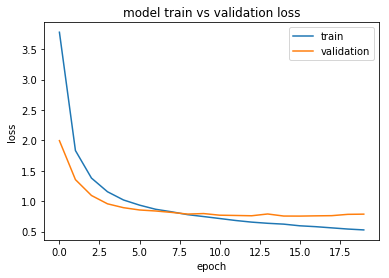

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

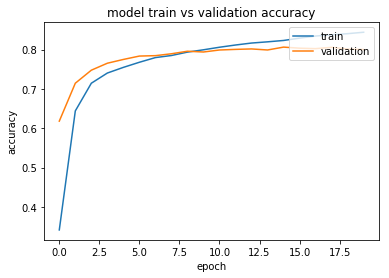

In [52]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()